IMPORTS

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import cv2

LOAD MODEL

In [2]:
model_name = "openai/clip-vit-base-patch16" # you can change model name here with patch size -- search in Hugging face.
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

In [3]:
categorie = [
    "airplane","ball","car",
    "cat","dolphin","face",
    "lotus","pickles","strawberry"
    ]
text_prompts = [f"a photo of a {label}"for label in categorie]

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        
        # Extraire les classes uniques des noms de fichiers (tout ce qui est avant le '_')
        self.classes = sorted(list(set(f.split('_')[0] for f in self.image_files)))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path)
        
        # Obtenir la classe à partir du nom du fichier
        class_name = img_name.split('_')[0]
        label = self.class_to_idx[class_name]
        
        return image, label

dataset = CustomDataset("./TP1_data/database")

def pil_collate_fn(batch):
    # batch is a list of (pil_image, label) pairs
    # Just return them as two lists (or lists of size 1 if batch_size=1)
    pil_images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    return pil_images, labels

dataloader = DataLoader(
    dataset,
    batch_size=1,  # can increase this if you like
    shuffle=True,
    collate_fn=pil_collate_fn
)

# Pour vérifier que tout fonctionne
print(f"Classes trouvées : {dataset.classes}")
print(f"Nombre total d'images : {len(dataset)}")

Classes trouvées : ['airplane', 'ball', 'car', 'cat', 'dolphin', 'face', 'lotus', 'pickles']
Nombre total d'images : 40


In [5]:
def detect_edges(pil_image):
    """
    Convertit une image PIL en niveaux de gris et applique la détection de contours.
    """
    # Convertir l'image PIL en tableau numpy
    image_np = np.array(pil_image)
    
    # Vérifier le nombre de canaux
    if len(image_np.shape) == 2:  # Image déjà en niveaux de gris (1 canal)
        gray_image = image_np
    else:  # Image en couleur (3 canaux)
        gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    # Appliquer la détection de contours avec Canny
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    
    # Convertir l'image de contours en PIL pour l'affichage
    edges_pil = Image.fromarray(edges)
    
    return edges_pil


In [6]:
def display_image_and_predictions(pil_image, true_label_idx, probs, text_prompts):
    """
    Affiche l'image donnée avec son étiquette réelle,
    ainsi que les probabilités pour chaque prompt textuel.
    """
    # Détecter les contours
    edges_pil = detect_edges(pil_image)
    
    # Afficher l'image originale et les contours
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(f"True Label: {categorie[true_label_idx]}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(edges_pil, cmap='gray')
    plt.axis('off')
    plt.title("Edges Detected")
    
    plt.show()

    # Afficher les probabilités
    print("Label probabilities:")
    for prompt, prob in zip(text_prompts, probs):
        print(f"{prompt}: {prob:.2%}")

    # Afficher la classe prédite
    predicted_class = text_prompts[probs.argmax()]
    print(f"Predicted class: {predicted_class}")
    print("-" * 50)


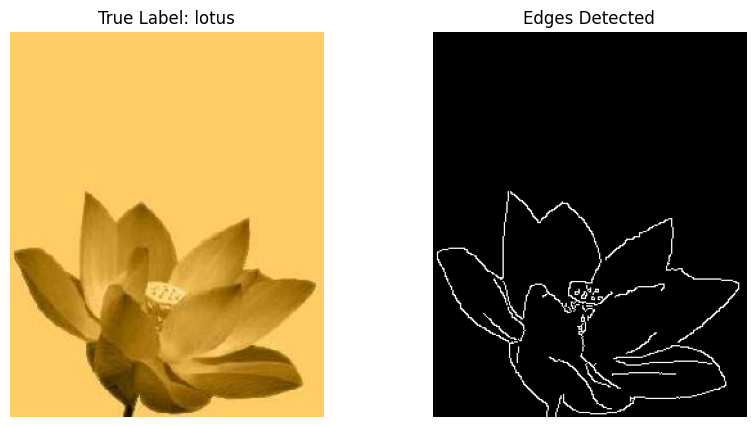

Label probabilities:
a photo of a airplane: 0.00%
a photo of a ball: 0.00%
a photo of a car: 0.00%
a photo of a cat: 0.00%
a photo of a dolphin: 0.00%
a photo of a face: 0.02%
a photo of a lotus: 99.96%
a photo of a pickles: 0.01%
a photo of a strawberry: 0.00%
Predicted class: a photo of a lotus
--------------------------------------------------


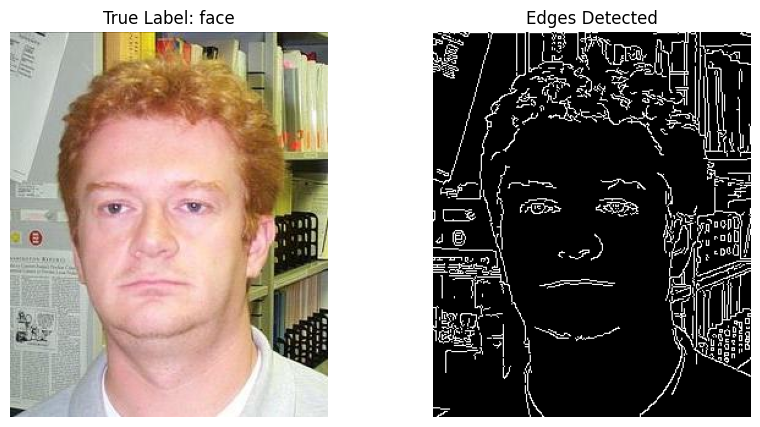

Label probabilities:
a photo of a airplane: 0.02%
a photo of a ball: 0.18%
a photo of a car: 0.20%
a photo of a cat: 0.28%
a photo of a dolphin: 0.02%
a photo of a face: 98.26%
a photo of a lotus: 0.00%
a photo of a pickles: 0.87%
a photo of a strawberry: 0.16%
Predicted class: a photo of a face
--------------------------------------------------


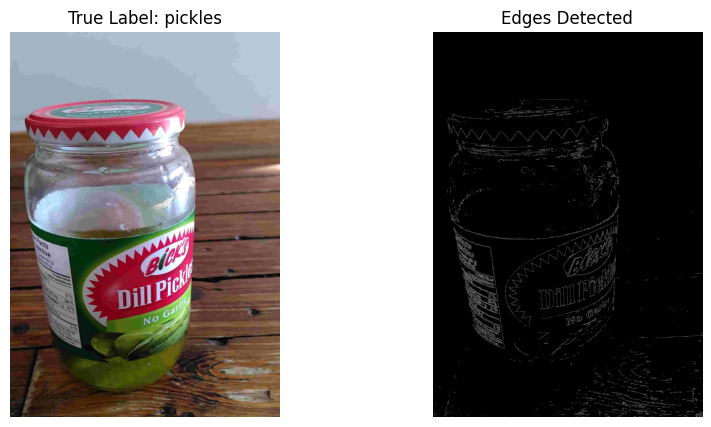

Label probabilities:
a photo of a airplane: 0.00%
a photo of a ball: 0.00%
a photo of a car: 0.00%
a photo of a cat: 0.00%
a photo of a dolphin: 0.00%
a photo of a face: 0.01%
a photo of a lotus: 0.00%
a photo of a pickles: 99.99%
a photo of a strawberry: 0.00%
Predicted class: a photo of a pickles
--------------------------------------------------


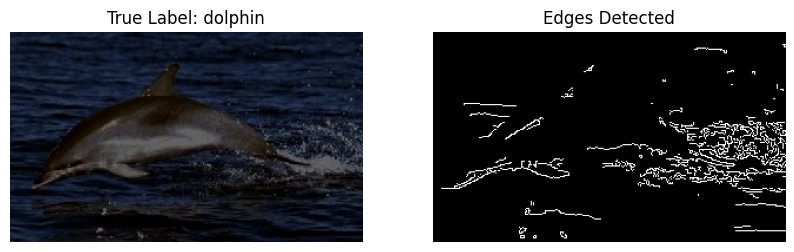

Label probabilities:
a photo of a airplane: 0.00%
a photo of a ball: 0.00%
a photo of a car: 0.00%
a photo of a cat: 0.00%
a photo of a dolphin: 99.99%
a photo of a face: 0.01%
a photo of a lotus: 0.00%
a photo of a pickles: 0.00%
a photo of a strawberry: 0.00%
Predicted class: a photo of a dolphin
--------------------------------------------------


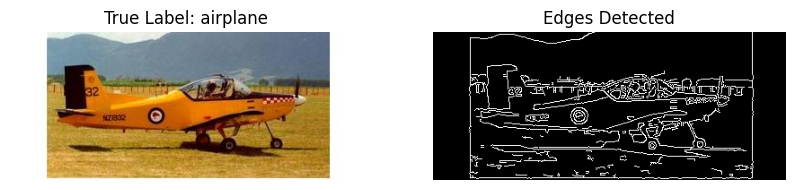

Label probabilities:
a photo of a airplane: 96.90%
a photo of a ball: 0.05%
a photo of a car: 2.28%
a photo of a cat: 0.12%
a photo of a dolphin: 0.01%
a photo of a face: 0.11%
a photo of a lotus: 0.39%
a photo of a pickles: 0.06%
a photo of a strawberry: 0.09%
Predicted class: a photo of a airplane
--------------------------------------------------


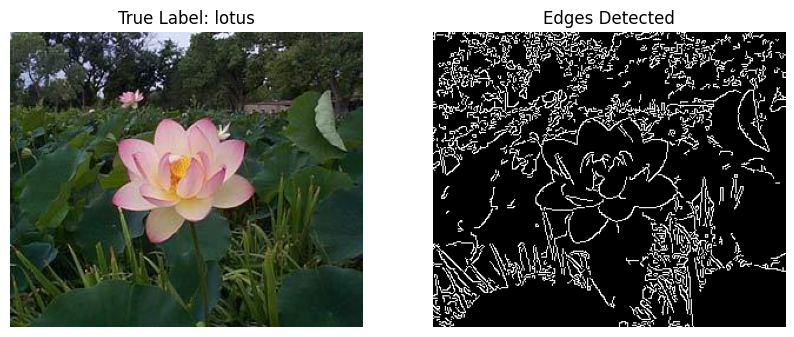

Label probabilities:
a photo of a airplane: 0.00%
a photo of a ball: 0.00%
a photo of a car: 0.00%
a photo of a cat: 0.00%
a photo of a dolphin: 0.00%
a photo of a face: 0.01%
a photo of a lotus: 99.99%
a photo of a pickles: 0.00%
a photo of a strawberry: 0.00%
Predicted class: a photo of a lotus
--------------------------------------------------


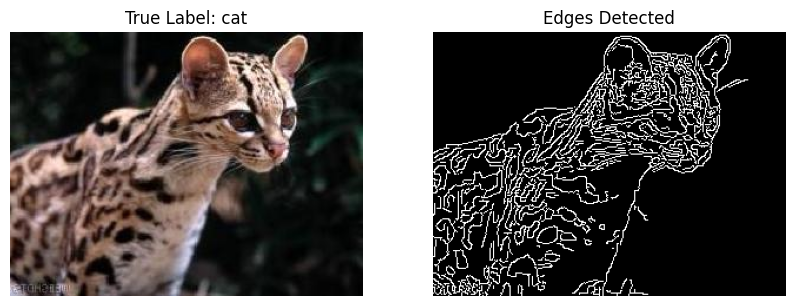

Label probabilities:
a photo of a airplane: 0.00%
a photo of a ball: 0.04%
a photo of a car: 0.08%
a photo of a cat: 98.85%
a photo of a dolphin: 0.00%
a photo of a face: 0.99%
a photo of a lotus: 0.00%
a photo of a pickles: 0.04%
a photo of a strawberry: 0.00%
Predicted class: a photo of a cat
--------------------------------------------------


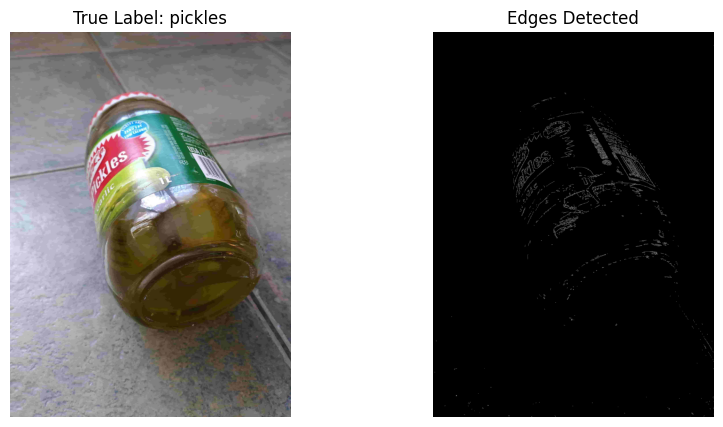

Label probabilities:
a photo of a airplane: 0.00%
a photo of a ball: 0.01%
a photo of a car: 0.01%
a photo of a cat: 0.03%
a photo of a dolphin: 0.01%
a photo of a face: 0.02%
a photo of a lotus: 0.01%
a photo of a pickles: 99.89%
a photo of a strawberry: 0.01%
Predicted class: a photo of a pickles
--------------------------------------------------


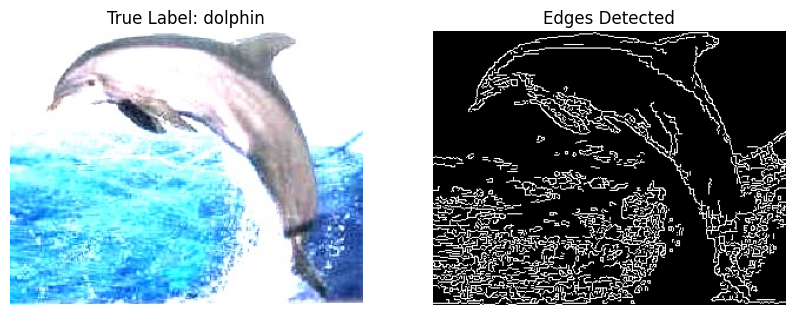

Label probabilities:
a photo of a airplane: 0.02%
a photo of a ball: 0.05%
a photo of a car: 0.01%
a photo of a cat: 0.03%
a photo of a dolphin: 99.87%
a photo of a face: 0.02%
a photo of a lotus: 0.00%
a photo of a pickles: 0.01%
a photo of a strawberry: 0.00%
Predicted class: a photo of a dolphin
--------------------------------------------------


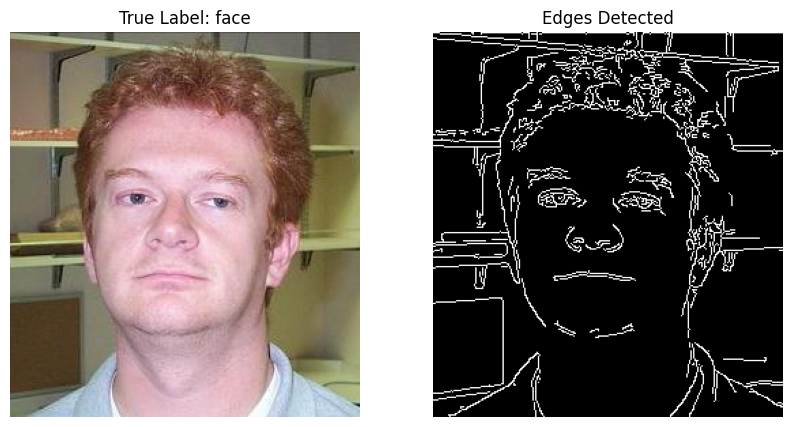

Label probabilities:
a photo of a airplane: 0.05%
a photo of a ball: 0.20%
a photo of a car: 0.28%
a photo of a cat: 0.32%
a photo of a dolphin: 0.02%
a photo of a face: 96.95%
a photo of a lotus: 0.00%
a photo of a pickles: 1.85%
a photo of a strawberry: 0.33%
Predicted class: a photo of a face
--------------------------------------------------


In [7]:
# Afficher les premières images avec les contours
num_samples_to_display = 10

for i, (pil_images, labels) in enumerate(dataloader):
    if i == num_samples_to_display:
        break

    # pil_images est une liste de taille 1 (car batch_size=1)
    pil_image = pil_images[0]
    label = labels[0]

    # Prétraiter l'image (PIL) et le texte avec CLIPProcessor
    inputs = processor(
        text=text_prompts,
        images=pil_image,
        return_tensors="pt",
        padding=True
    )

    # Inférence
    with torch.no_grad():
        outputs = model(**inputs)

    # Obtenir les probabilités
    logits_per_image = outputs.logits_per_image  # shape [batch_size, num_text_prompts]
    probs = logits_per_image.softmax(dim=1).squeeze()

    # Afficher le résultat
    display_image_and_predictions(pil_image, label, probs, text_prompts)

Test on Query images

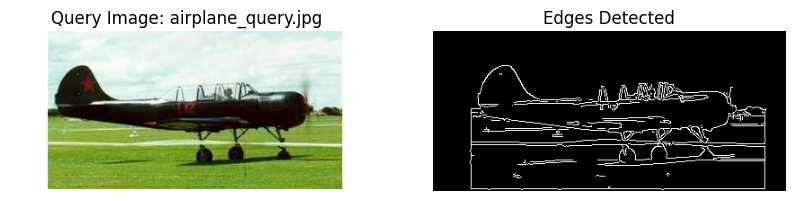

Results for airplane_query.jpg:
a photo of a airplane: 95.51%
a photo of a ball: 0.08%
a photo of a car: 3.70%
a photo of a cat: 0.30%
a photo of a dolphin: 0.01%
a photo of a face: 0.12%
a photo of a lotus: 0.21%
a photo of a pickles: 0.03%
a photo of a strawberry: 0.04%
Predicted class: a photo of a airplane
--------------------------------------------------


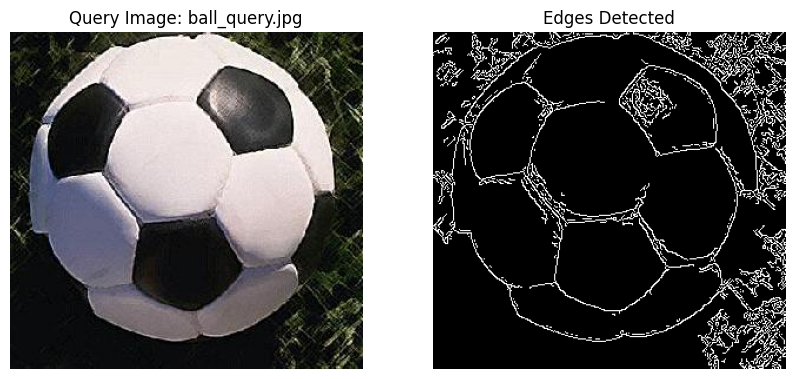

Results for ball_query.jpg:
a photo of a airplane: 0.01%
a photo of a ball: 99.74%
a photo of a car: 0.03%
a photo of a cat: 0.01%
a photo of a dolphin: 0.00%
a photo of a face: 0.14%
a photo of a lotus: 0.00%
a photo of a pickles: 0.03%
a photo of a strawberry: 0.05%
Predicted class: a photo of a ball
--------------------------------------------------


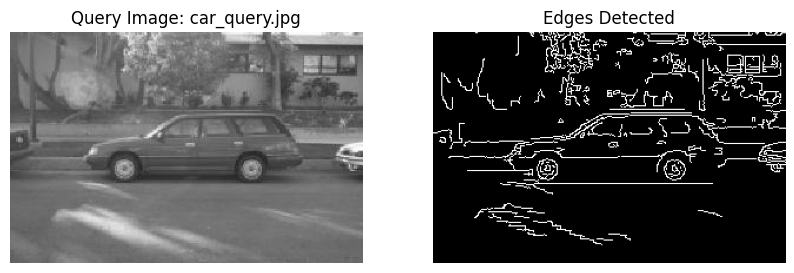

Results for car_query.jpg:
a photo of a airplane: 0.01%
a photo of a ball: 0.02%
a photo of a car: 99.90%
a photo of a cat: 0.02%
a photo of a dolphin: 0.00%
a photo of a face: 0.02%
a photo of a lotus: 0.02%
a photo of a pickles: 0.01%
a photo of a strawberry: 0.00%
Predicted class: a photo of a car
--------------------------------------------------


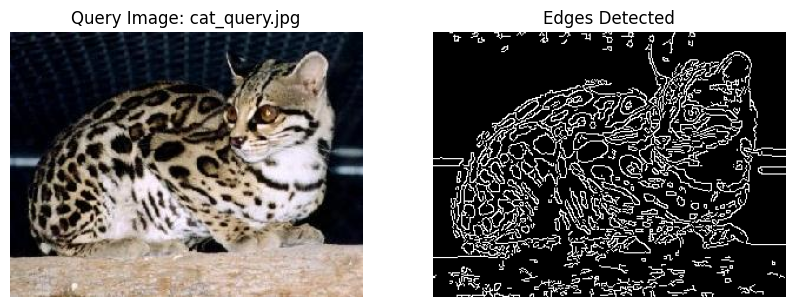

Results for cat_query.jpg:
a photo of a airplane: 0.00%
a photo of a ball: 0.07%
a photo of a car: 0.24%
a photo of a cat: 99.06%
a photo of a dolphin: 0.00%
a photo of a face: 0.58%
a photo of a lotus: 0.00%
a photo of a pickles: 0.06%
a photo of a strawberry: 0.00%
Predicted class: a photo of a cat
--------------------------------------------------


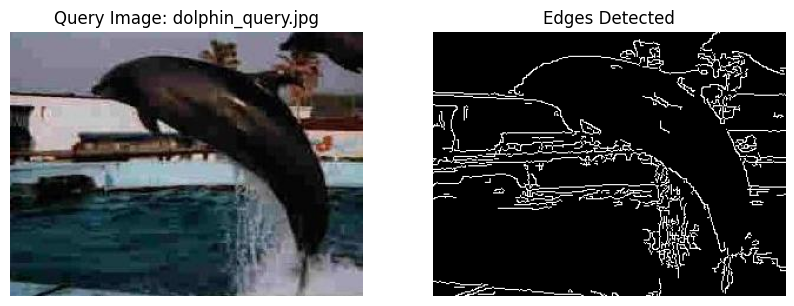

Results for dolphin_query.jpg:
a photo of a airplane: 0.07%
a photo of a ball: 0.00%
a photo of a car: 0.02%
a photo of a cat: 0.11%
a photo of a dolphin: 99.77%
a photo of a face: 0.00%
a photo of a lotus: 0.00%
a photo of a pickles: 0.02%
a photo of a strawberry: 0.00%
Predicted class: a photo of a dolphin
--------------------------------------------------


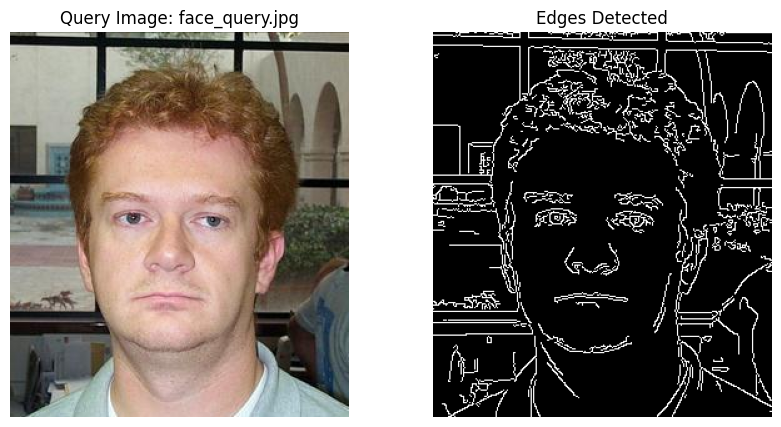

Results for face_query.jpg:
a photo of a airplane: 0.01%
a photo of a ball: 0.05%
a photo of a car: 0.12%
a photo of a cat: 0.09%
a photo of a dolphin: 0.02%
a photo of a face: 99.08%
a photo of a lotus: 0.00%
a photo of a pickles: 0.46%
a photo of a strawberry: 0.15%
Predicted class: a photo of a face
--------------------------------------------------


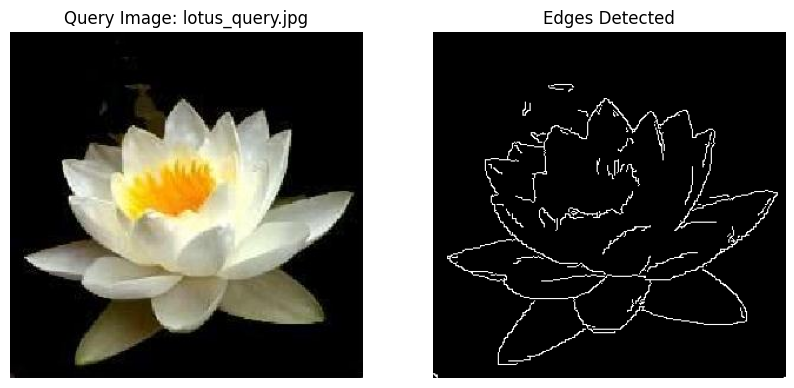

Results for lotus_query.jpg:
a photo of a airplane: 0.01%
a photo of a ball: 0.01%
a photo of a car: 0.02%
a photo of a cat: 0.01%
a photo of a dolphin: 0.00%
a photo of a face: 0.16%
a photo of a lotus: 99.77%
a photo of a pickles: 0.01%
a photo of a strawberry: 0.00%
Predicted class: a photo of a lotus
--------------------------------------------------


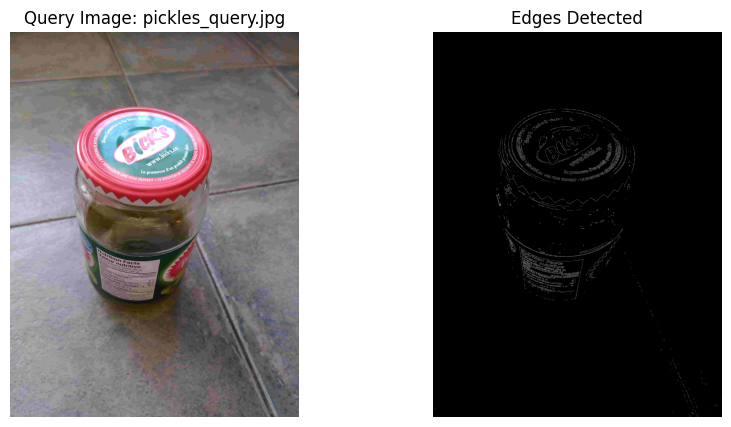

Results for pickles_query.jpg:
a photo of a airplane: 0.00%
a photo of a ball: 0.01%
a photo of a car: 0.00%
a photo of a cat: 0.01%
a photo of a dolphin: 0.00%
a photo of a face: 0.01%
a photo of a lotus: 0.00%
a photo of a pickles: 99.96%
a photo of a strawberry: 0.00%
Predicted class: a photo of a pickles
--------------------------------------------------


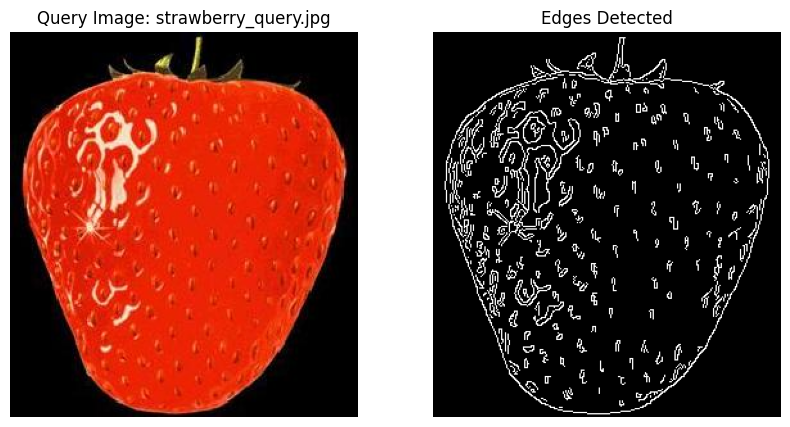

Results for strawberry_query.jpg:
a photo of a airplane: 0.00%
a photo of a ball: 0.01%
a photo of a car: 0.00%
a photo of a cat: 0.00%
a photo of a dolphin: 0.00%
a photo of a face: 0.01%
a photo of a lotus: 0.00%
a photo of a pickles: 0.00%
a photo of a strawberry: 99.98%
Predicted class: a photo of a strawberry
--------------------------------------------------


In [8]:
# Dataset pour les images de requête
class CustomQueryDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') and '_query' in f]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        return image, img_name  # Retourne l'image et le nom du fichier pour référence

# Charger les images de requête
query_dataset = CustomQueryDataset("./TP1_data")

# Fonction pour tester les images de requête
def test_query_images():
    for idx in range(len(query_dataset)):
        pil_image, img_name = query_dataset[idx]

        # Prétraiter l'image avec CLIPProcessor
        inputs = processor(
            text=text_prompts,
            images=pil_image,
            return_tensors="pt",
            padding=True
        )

        # Effectuer l'inférence avec le modèle CLIP
        with torch.no_grad():
            outputs = model(**inputs)

        # Obtenir les probabilités
        logits_per_image = outputs.logits_per_image  # shape [1, num_text_prompts]
        probs = logits_per_image.softmax(dim=-1).squeeze()

        # Détecter les contours
        edges_pil = detect_edges(pil_image)

        # Afficher l'image originale et les contours
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(pil_image)
        plt.axis('off')
        plt.title(f"Query Image: {img_name}")

        plt.subplot(1, 2, 2)
        plt.imshow(edges_pil, cmap='gray')
        plt.axis('off')
        plt.title("Edges Detected")

        plt.show()

        # Afficher les résultats
        print(f"Results for {img_name}:")
        for prompt, prob in zip(text_prompts, probs):
            print(f"{prompt}: {prob:.2%}")

        predicted_class = text_prompts[probs.argmax()]
        print(f"Predicted class: {predicted_class}")
        print("-" * 50)

# Exécuter la fonction pour tester les images de requête
test_query_images()